# Experiments with random fields

I will start with a setup similar to the basic case (notebook 2).

In [1]:
import os, sys
sys.path.append('../')

from shell import ShellModel, FieldTransformer
import shell.observable as obs
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import imagine as img
import shell.visualization as visu

In [2]:
shell_model = ShellModel(V0=0.0153*u.pc/u.yr,
                         a=1.3, b=10, R=50*u.pc,
                         elapsed_time=1300*u.yr)

In [3]:
L = 70*u.pc; N = 128

grid = img.UniformGrid(# coordinate values for edges of the grid box
                       box=[[-L,L],[-L,L],[-L,L]], 
                       # Grid resolution
                       resolution=[N, N, N])

In [4]:
field_transformer = FieldTransformer(grid, shell_model)

## Gaussian random field with flat spectrum

To get a feeling of a zero-divergence random field, let us first generate a simple Gaussian random field

In [5]:
n0 = np.ones(grid.shape) * u.cm**(-3) # Constant unit density

In [6]:
from galmag.util import derive

mu = 0
sigma = 0.0778 # magic number to generate Brms~0.5

# Defines a random vector potential 
A_rnd = {} # Dictionary of vector components
for i, c in enumerate(('x','y','z')):
    A_rnd[c] = np.random.normal(mu, sigma, grid.resolution.prod())
    A_rnd[c] = A_rnd[c].reshape(grid.resolution)

# Prepares the derivatives to compute the curl
dBi_dj ={}
for i, c in enumerate(['x','y','z']):
    for j, d in enumerate(['x','y','z']):
        dj = (grid.box[j][-1]-grid.box[j][0])/float(grid.resolution[j])
        dBi_dj[c,d] = derive(A_rnd[c],dj, axis=j)

# Computes the curl of A_rnd
tmpBrnd = {}        
tmpBrnd['x'] = dBi_dj['z','y'] -  dBi_dj['y','z']
tmpBrnd['y'] = dBi_dj['x','z'] -  dBi_dj['z','x']
tmpBrnd['z'] = dBi_dj['y','x'] -  dBi_dj['x','y']

del dBi_dj; del A_rnd

for c in tmpBrnd:
    print('B{0}: mean = {1:.2g}  std = {2:.3f}'.format(c, 
                                                tmpBrnd[c].mean(),
                                                tmpBrnd[c].std()))

Bx: mean = 9.4e-07  std = 0.078
By: mean = -3.1e-05  std = 0.078
Bz: mean = 5.8e-06  std = 0.077


again, we can substitute this field by anything we imagine.

The field and density after the SN explosion is computed by the following line:

In [7]:
n, [Bx, By, Bz] = field_transformer(n0, [tmpBrnd[k]*u.microgauss for k in ('x','y','z')])

Now we can examine our results

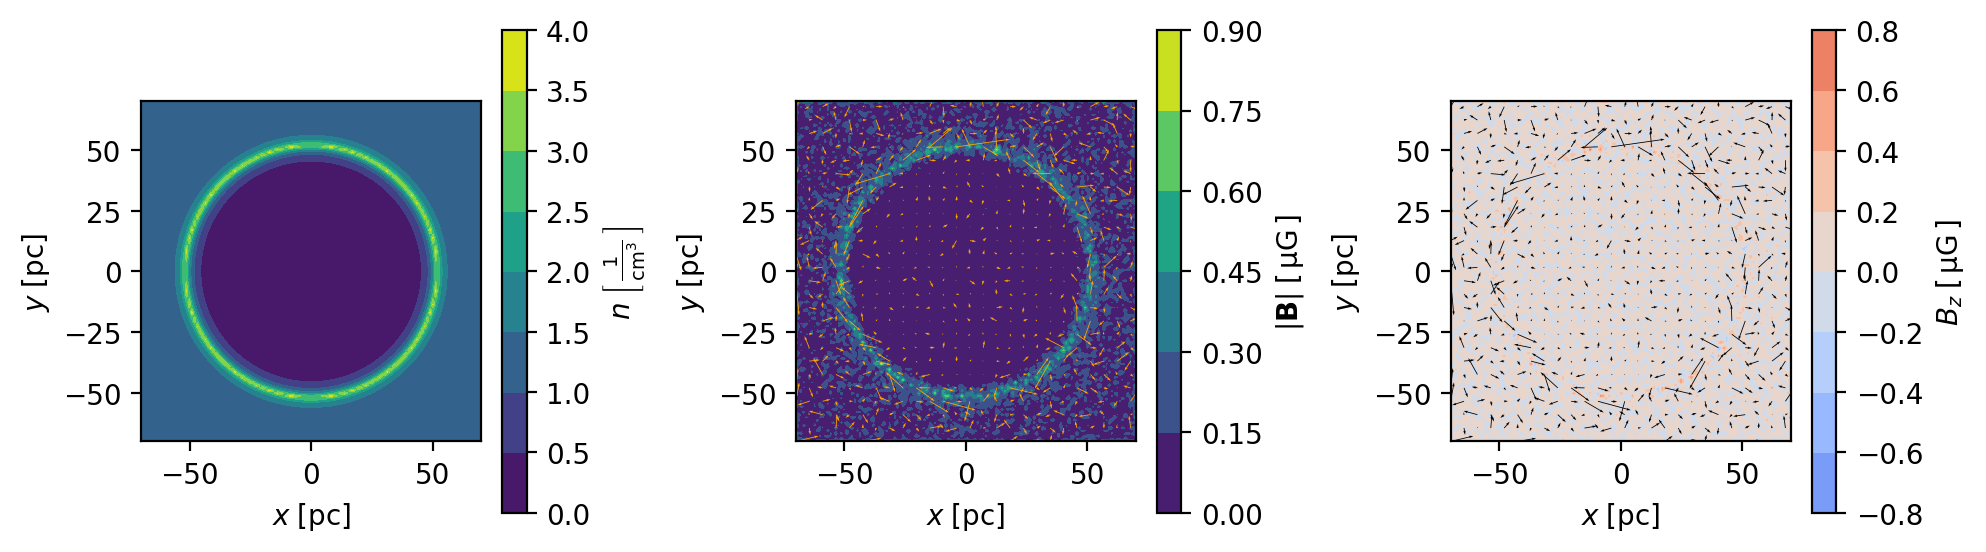

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3),dpi=200)
visu.plot_scalar_xy(grid, n, ax=ax1)
visu.plot_vector_xy(grid, [Bx, By, Bz], ax=ax2, skip=5)
visu.plot_vector_xy(grid, [Bx, By, Bz], name='B_z', skip=5, ax=ax3,
                    quiver_color='black', show_z_component=True)
plt.tight_layout()

### Computing observables

In [9]:
lamb = 20*u.cm
ne = n
ncr = 1*u.cm**-3

I, U, Q = obs.compute_stokes_parameters(grid, lamb, Bx, By, Bz, ne, ncr)

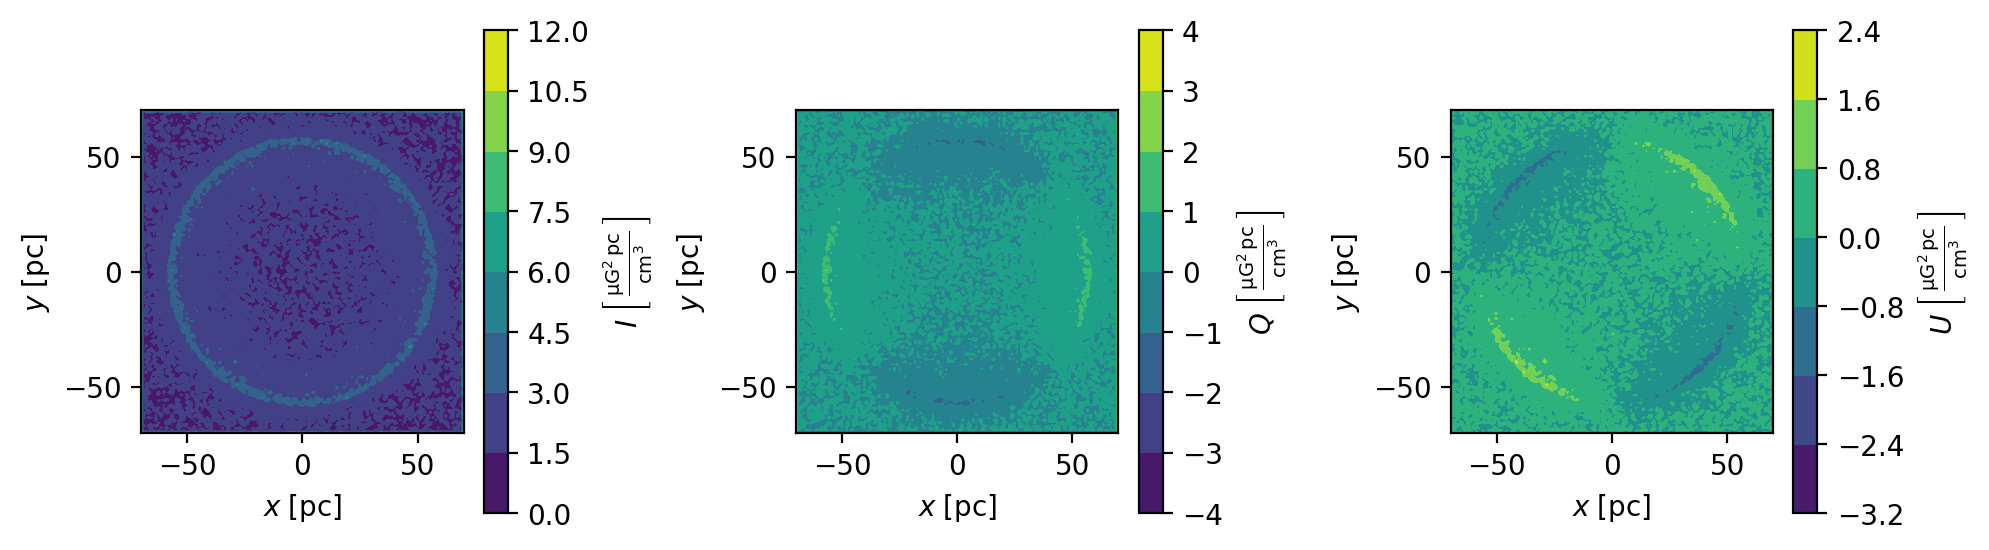

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3),dpi=200)
visu.plot_scalar_xy(grid, I,name='I', ax=ax1)
visu.plot_scalar_xy(grid, Q,name='Q', ax=ax2)
visu.plot_scalar_xy(grid, U,name='U', ax=ax3)
plt.tight_layout()

In [11]:
fraction = np.sqrt((Q**2+U**2)/I**2)

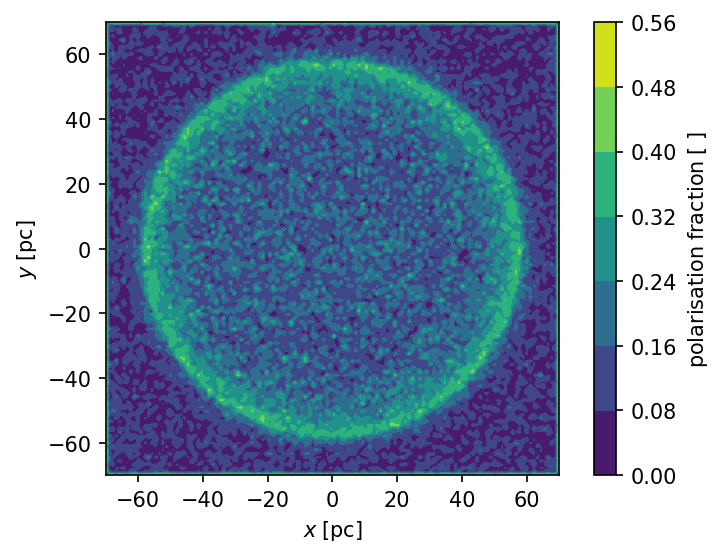

In [12]:
visu.plot_scalar_xy(grid, fraction, name=r'{\rm polarisation\;fraction}');

## Random field with arbitrary spectrum